**IMPORT MODUL**

In [347]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

**IMPORT DATA**

In [366]:
data = pd.read_csv('winequality-red.csv')
data.head(268)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
263,7.9,0.37,0.23,1.8,0.077,23.0,49.0,0.99630,3.28,0.67,9.3,5
264,12.5,0.56,0.49,2.4,0.064,5.0,27.0,0.99990,3.08,0.87,10.9,5
265,11.8,0.26,0.52,1.8,0.071,6.0,10.0,0.99680,3.20,0.72,10.2,7
266,8.1,0.87,0.00,3.3,0.096,26.0,61.0,1.00025,3.60,0.72,9.8,4


**PLOTING DATA KE HEATMAP**

Dilihat dari heatmap semua komponen saling berkorelasi sehingga digunakan semua komponen dalam menentukan kualitas wine

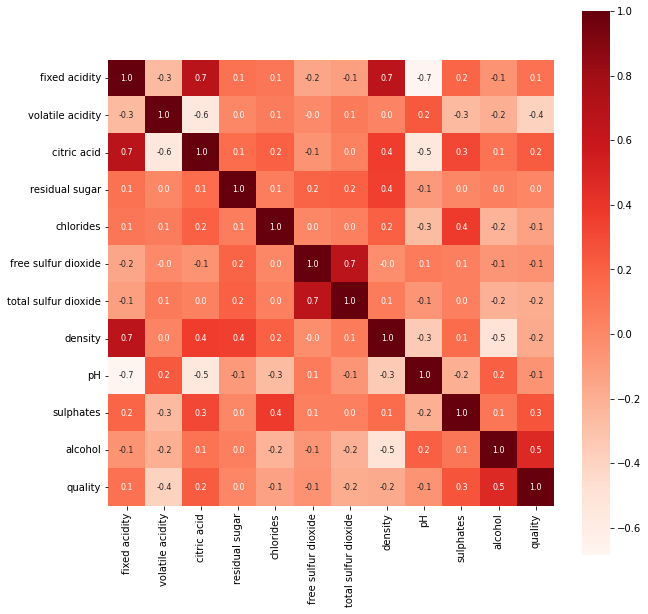

In [349]:
plt.figure(figsize = (10, 10))
sns.heatmap(data.corr(), cbar = True, square = True, fmt = '.1f', annot = True, annot_kws = {'size':8}, cmap = 'Reds')

**BINARISASI LABEL QUALITY**

Wine dengan quality 3 sampai 6 masuk kedalam kategori 0 atau Bad Wine

Wine dengan quality 7 sampai 8 masuk kedalam kategori 1 atau Good Wine

In [350]:
# binarization on quality label
quality_binarization = data['quality'].apply(lambda y_value: 1 if y_value >= 7 else  0)

# convert quality_binarization into DataFrame
new_quality = pd.DataFrame(quality_binarization)

**MEMISAHKAN DATA TRAINING DAN DATA TESTING**

Data Training = 80% dari dataset

Data Testing = 20% dari dataset

In [360]:
X = data.iloc[:, :-1].values
Y = new_quality.iloc[:, -1].values.reshape(-1,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=41)

**ALGORITMA DECISION TREE CLASSIFIER**

In [352]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        
        # atribut decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # atribut leaf node
        self.value = value

In [367]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    # recursive function to build the tree    
    def build_tree(self, dataset, curr_depth=0):
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    # function to find the best split
    def get_best_split(self, dataset, num_samples, num_features):
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    # funtion to split the data
    def split(self, dataset, feature_index, threshold):
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    # function to compute information gain
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    # function to compute entropy
    def entropy(self, y):
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    # function to compute gini index
    def gini_index(self, y):
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini

    # function to compute leaf node    
    def calculate_leaf_value(self, Y):
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    # function to print the tree
    def print_tree(self, tree=None, indent=" "):
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    # function to train the tree
    def fit(self, X, Y):
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    # function to predict new dataset
    def predict(self, X):
        
        predictions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    # function to predict a single data point
    def make_prediction(self, x, tree):
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

**MEMBUAT OBJEK CLASSIFIER**

In [354]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
classifier.fit(X_train,Y_train)
classifier.print_tree()

X_10 <= 10.9 ? 0.030622084571308328
 left:X_9 <= 0.67 ? 0.006176747016306883
  left:X_3 <= 1.2 ? 0.0014071898164856739
    left:0.0
    right:X_4 <= 0.062 ? 0.0009725073642956744
        left:0.0
        right:0.0
  right:X_0 <= 11.5 ? 0.028601226602465557
    left:X_4 <= 0.061 ? 0.021458246370039513
        left:0.0
        right:0.0
    right:X_1 <= 0.33 ? 0.1601307189542484
        left:1.0
        right:0.0
 right:X_9 <= 0.68 ? 0.04517501259105927
  left:X_1 <= 0.35 ? 0.03626687860130773
    left:X_3 <= 3.6 ? 0.06274946625823813
        left:0.0
        right:1.0
    right:X_2 <= 0.73 ? 0.01984498703774465
        left:0.0
        right:1.0
  right:X_10 <= 11.5 ? 0.06400909129083732
    left:X_1 <= 0.37 ? 0.06471999801505018
        left:1.0
        right:0.0
    right:X_5 <= 18.0 ? 0.057309941520467866
        left:1.0
        right:0.0


**MENGHITUNG AKURASI PENGETESAN**

Perhitungan akurasi menggunakan confusion matriks

In [355]:
Y_pred = classifier.predict(X_test) 
accuracy_score(Y_test, Y_pred)

0.88125

**PENGETESAN MANUAL**

In [356]:
input_data = (7.9,0.35,0.46,3.6,0.078,15.0,37.0,0.9973,3.35,0.86,12.8)

# changing the input_data to a numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the numpy array as we are predicting the label for only one instance
input_data_reshape = input_data_as_numpy_array.reshape(1, -1)

prediction = classifier.predict(input_data_reshape)
print(prediction)

if (prediction[0] == 1):
  print('Good Quality')
else:
  print('Bad Quality')

[1.0]
Good Quality
